In [1]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/scripts/sampling/configs/svd_interpolation.yaml"
)
print(config)
config["model"]["params"][
    "ckpt_path"
] = "/data2/Experiments/generative_models/logs/2024-03-01T18-56-20_example_training-svd_interpolation/checkpoints/last.ckpt"
model = instantiate_from_config(config.model)

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'scale_factor': 0.18215, 'disable_first_stage_autocast': True, 'ckpt_path': '/vol/paramonos2/projects/antoni/code/Personal/generative-models/logs/2024-03-01T18-56-20_example_training-svd_interpolation/checkpoints/last.ckpt', 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.Denoiser', 'params': {'scaling_config': {'target': 'sgm.modules.diffusionmodules.denoiser_scaling.VScalingWithEDMcNoise'}}}, 'network_wrapper': {'target': 'sgm.modules.diffusionmodules.wrappers.InterpolationWrapper', 'params': {'im_size': [512, 512], 'n_channels': 4, 'starting_mask_method': 'zeros'}}, 'network_config': {'target': 'sgm.modules.diffusionmodules.video_model.VideoUNet', 'params': {'adm_in_channels': 768, 'num_classes': 'sequential', 'use_checkpoint': True, 'in_channels': 9, 'out_channels': 4, 'model_channels': 320, 'attention_resolutions': [4, 2, 1], 'num_res_blocks': 2, 'channel_mult': [1, 2, 4, 4], 'num_head_cha

In [5]:
model.model.learned_mask.sum((1, 2))

tensor([ 6.4763, -4.7001,  1.2960,  3.1759], grad_fn=<SumBackward1>)

In [25]:
from torchvision.io import read_video
import torch

video_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001.mp4"
resolution = 512
device = torch.device("cuda")

video, audio, info = read_video(video_path, pts_unit="sec", output_format="TCHW")

from torchvision.transforms import Resize

resize = Resize((resolution, resolution))
video = resize(video)
print(video.shape)

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1000, 3, 512, 512])


In [33]:
audio_path = "/data2/Datasets/HDTF/audio/WRA_BobbySchilling_001_whisper_emb.pt"
audio = torch.load(audio_path)
print(audio.shape)

torch.Size([1000, 2, 1280])


In [19]:
video.min(), video.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [ ]:
model.first_stage_model.encoder

In [26]:
model = model.to(device)
encoded = model.conditioner.embedders[3]((video[:2].to(device).float() / 255.0) * 2 - 1)

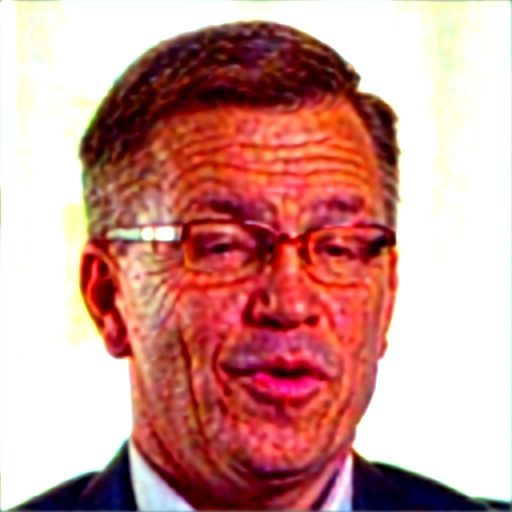

In [27]:
from PIL import Image
import numpy as np

decoded = model.decode_first_stage(encoded[:, 4:])
img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [28]:
from safetensors.torch import load_file

latent_path = "/data2/Datasets/HDTF/cropped_videos_original/WRA_BobbySchilling_001_video_512_latent.safetensors"

latent = load_file(latent_path)
latent["latents"].shape

torch.Size([1025, 4, 64, 64])

In [30]:
decoded = model.decode_first_stage(latent["latents"][:1].to(device))

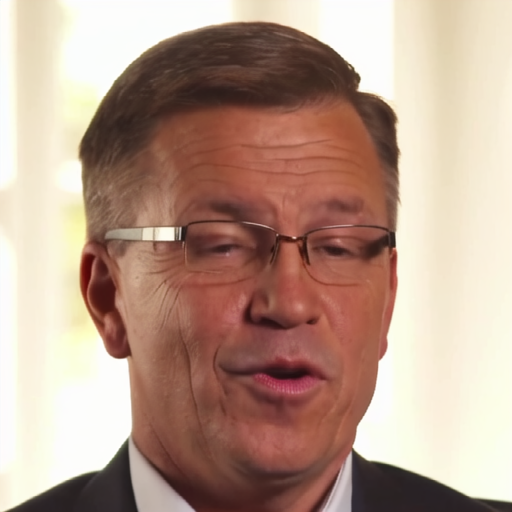

In [31]:
from PIL import Image
import numpy as np

img = Image.fromarray(np.uint8((decoded[0].clip(-1, 1).cpu().numpy().transpose(1, 2, 0) + 1) * 255 / 2))
display(img)

In [1]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/inference/sd_2_1.yaml"
)
print(config)
config["model"]["params"][
    "ckpt_path"
] = "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/v2-1_512-ema-pruned.safetensors"
model = instantiate_from_config(config.model)

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'scale_factor': 0.18215, 'disable_first_stage_autocast': True, 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.DiscreteDenoiser', 'params': {'num_idx': 1000, 'scaling_config': {'target': 'sgm.modules.diffusionmodules.denoiser_scaling.EpsScaling'}, 'discretization_config': {'target': 'sgm.modules.diffusionmodules.discretizer.LegacyDDPMDiscretization'}}}, 'network_config': {'target': 'sgm.modules.diffusionmodules.openaimodel.UNetModel', 'params': {'use_checkpoint': True, 'in_channels': 4, 'out_channels': 4, 'model_channels': 320, 'attention_resolutions': [4, 2, 1], 'num_res_blocks': 2, 'channel_mult': [1, 2, 4, 4], 'num_head_channels': 64, 'use_linear_in_transformer': True, 'transformer_depth': 1, 'context_dim': 1024}}, 'conditioner_config': {'target': 'sgm.modules.GeneralConditioner', 'params': {'emb_models': [{'is_trainable': False, 'input_key': 'txt', 'target': 'sgm.modules.encoders.modules.Fr